# SDGP SE-12 NerveSeg-US Data Model

## Pre-Processing of Images for the ML Model

For our SDGP project we will use this procedure for the pre-processing of data. Since the dataset is unlabelled and using unsupervised learning approach

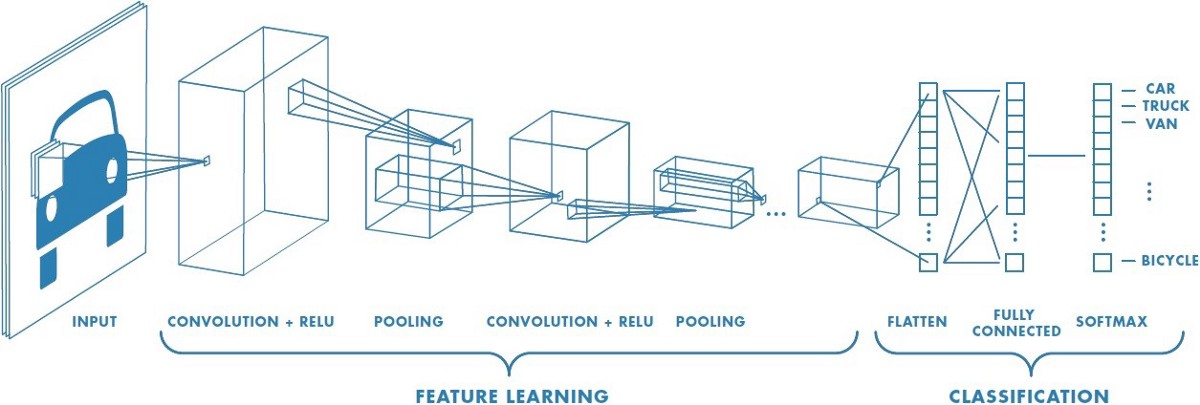

In [70]:
#Importing OS Module
import os

#Importing re pattern in RegEx
import re

#Importing numpy
import numpy as np

#Importing Pandas
import pandas as pd

#importing pyplot interface
import matplotlib.pyplot as plt
import re
#importing openCV for computer vision
import cv2
#Importing other dependencies in order to pre process
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold
#Importing tensorflow I/O
import tensorflow_io as tfio

#Importing Keras
import keras

#Importing tensorflow
import tensorflow as tf
#Importing keras dependencies

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
plt.style.use("ggplot")
%matplotlib inline
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers.core import Lambda, RepeatVector, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from PIL import Image,ImageFilter
K.set_image_data_format('channels_last')

Creating the dataframes for .tif images of both training data sets with masks and the test dataset

In [3]:
#Create train and test dataframes of images
file_path=pd.DataFrame({'image_path':os.listdir('D:\\2nd Year Tutorials\\SDGP Project\\SDGP Project\\Project-NerveSeg-US\\Back-End\\train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('D:\\2nd Year Tutorials\\SDGP Project\\SDGP Project\\Project-NerveSeg-US\\Back-End\\test')})

Getting subject and image name from train data set

In [4]:
#Paths for the dataset names including subject and image name
#Split using _ in the file name for the subjec
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
#Split using . for the image name in the path
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])
#Setting regEx for the test images
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

Adding two columns for the above data named "Image Name" and "Subject"

In [5]:
#Adding two columns image name and subject name
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name

adding file location to file name.

In [6]:
#Adding file location to file name
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)

Seperating masked image from the train images to feed in machine learning model

In [7]:
#Seperating masked images from the train images
#for the masked path
mask=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
images=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
masks=file_path.loc[msk]
imagess=file_path.loc[img]

Aligning both image sets to to be concatenated later in the model

In [8]:
#For Concatenation
#Masked Images in trained data goes as image name and subject name
msk=msk.sort_values(by=['image_name','subject_name'])
#The raw images will be added as another set
img=img.sort_values(by=['image_name','subject_name'])

Adding marked images to the data frames

In [9]:
#Adding mask image path to the data frame
img['mask_path']=msk.image_path.values

In [10]:
#printing the number of objects that we would be training
print('Number of unique subjects',len(img.subject_name.value_counts()))
print('Number of images per subject',len(img.image_name.value_counts()))

Number of unique subjects 47
Number of images per subject 120


In [11]:
#Viewing tables for the progress check
img.head()

,image_path,image_name,subject_name,mask_path
2398,train/1_1.tif,1,1,train/1_1_mask.tif
0,train/10_1.tif,1,10,train/10_1_mask.tif
240,train/11_1.tif,1,11,train/11_1_mask.tif
480,train/12_1.tif,1,12,train/12_1_mask.tif
720,train/13_1.tif,1,13,train/13_1_mask.tif


We will be adding an RGB layer for the preprocessing mask to better segmentation of data 

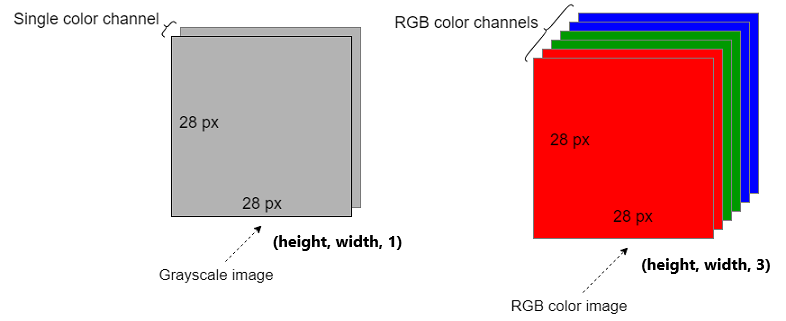

Visualizing a single ultrasound image and its simple mask and the new RGB Mask

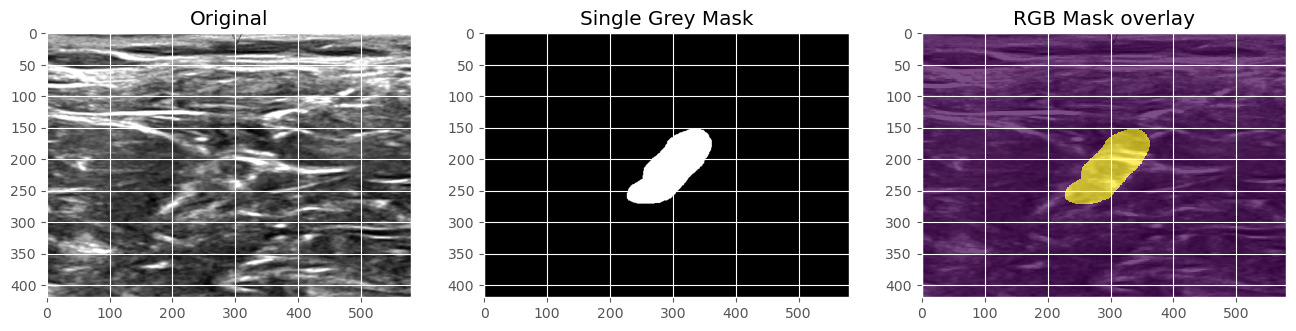

In [12]:
#Visualising a single ultra sound and its simple RGB Mask
#Getting from Masked path
#A numpy array to get the image paths and its susidieries
imgr=np.array(Image.open(img.iloc[5].image_path))
image1= np.array(Image.open(img.iloc[5].mask_path))
#Using matplotlib librabru to have
figure, axis = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img_arr, cmap = 'gray')
ax[0].set_title('Original')

#Setting up titles for the masks
axis[1].imshow(image1_mask, cmap = 'gray')
axis[1].set_title('Single Grey Mask')
axis[2].imshow(img_arr, cmap = 'gray', interpolation = 'none')
axis[2].imshow(image1_mask, interpolation = 'none', alpha = 0.7)
axis[2].set_title('RGB Mask overlay')
plt.show()


In [13]:
#Setting up array to store all images in 12 * 12 resized format
X1 = np.zeros((len(img), 12, 12), dtype=np.float32)
for i in range(len(img)):
  img1=cv2.imread(img.image_path.iloc[i],cv2.IMREAD_GRAYSCALE)
  img1=resize(img1, (12, 12), mode = 'constant', preserve_range = True)
  X1[i]=img1

In [15]:
#Progress bar
from tqdm import tqdm

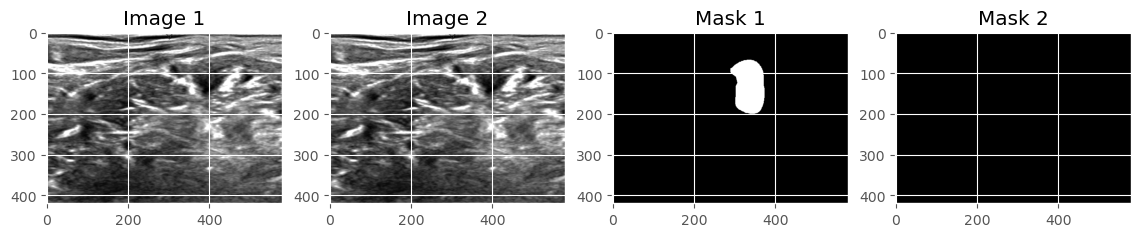

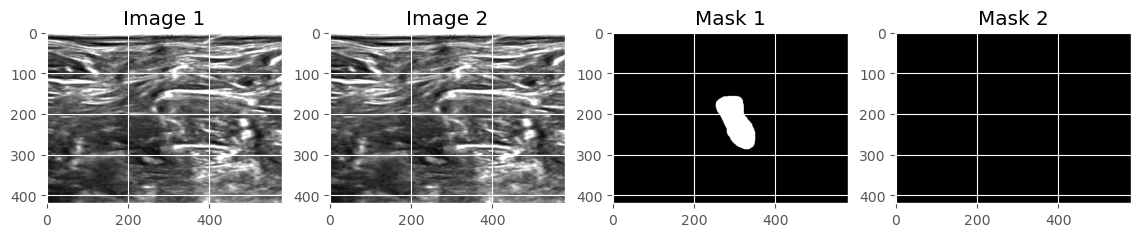

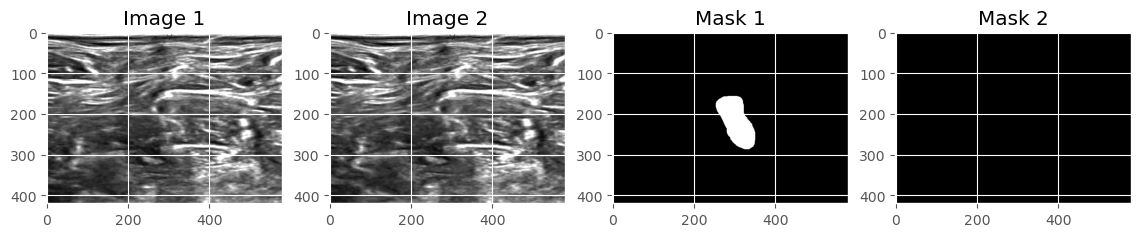

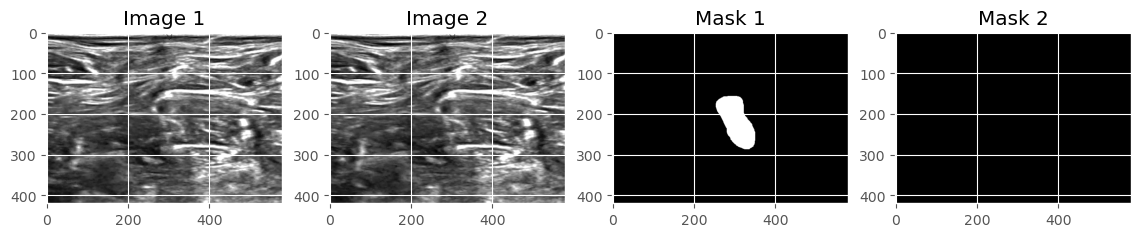

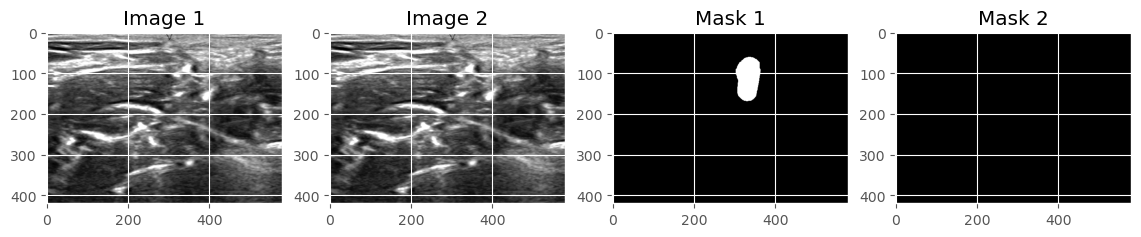

In [17]:
#plotting few of the conflicting image and mask pairs
cnt=0
for i in conf:
  fig,ax=plt.subplots(1,4,figsize=(14,7))
  cnt+=1
  img=cv2.imread(img.image_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  axis[0].imshow(img1,cmap='gray')
  axis[0].set_title('Image 1')
  img2=cv2.imread(img.image_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  axis[1].imshow(img2,cmap='gray')
  axis[1].set_title('Image 2')
  msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  axis[2].imshow(msk1,cmap='gray')
  axis[2].set_title('Mask 1')
  msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  axis[3].imshow(msk2,cmap='gray')
  axis[3].set_title('Mask 2')
  if cnt==5:
    break

In [14]:
#Finding similarity between resizes images and storing it in a dictionary
#Progress Bar using a tqdm module
from tqdm import tqdm
sim=dict()
for i in tqdm(range(len(X1))):
  for j in range(len(X1)):
      if i!=j:
        if tuple(sorted((i,j))) not in sim.keys():
          simil=ssim(X1[i],X1[j])
          if abs(simil)>0.95:
            sim[tuple(sorted((i,j)))]=simil

100%|████████████████████████████████████████████████████████████████████████████| 5635/5635 [1:48:19<00:00,  1.15s/it]


In [16]:
#storing conflicting images keys in a list if they similarity is>0.999 in the data set
conf=[]
for i in tqdm(sim.keys()):
  if sim[i]>0.999:
    msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
    if msk1.any()!=msk2.any():
      conf.append(i)

100%|██████████████████████████████████████████████████████████████████████████| 18826/18826 [00:14<00:00, 1325.04it/s]


In [18]:
#out of conflicting image pair dropping the image that doesn't contains a mask
indices=[img.iloc[i[1]].name if cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE).any()==True else img.iloc[i[0]].name for i in conf]
indices=list(set(indices))
img.drop(indices,axis=0,inplace=True)

In [19]:
#saving the info to a csv file named dup_rec.csv
img.to_csv('dup_rem.csv')

## Classification Model

Loading the dataframe containing images after removing conflicting images

In [55]:
#installing dependencies

import tensorflow_io as tfio
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
#import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

  Using cached Keras-2.4.1-py2.py3-none-any.whl (169 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)
  Using cached protobuf-4.22.1-cp39-cp39-win_amd64.whl (420 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.11.1-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.11.1-cp39-cp39-win_amd64.whl (266.3 MB)
  Using cached tensorflow-2.11.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached tensorflow-2.10.0-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cac

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sanda\\anaconda3\\Lib\\site-packages\\numpy\\.libs\\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [56]:
#loading the dataframe containing images after removing conflicting images
df=pd.read_csv('D:\\2nd Year Tutorials\\SDGP Project\\SDGP Project\\Project-NerveSeg-US\\Back-End\\train_masks.csv')
img=pd.read_csv('D:\\2nd Year Tutorials\\SDGP Project\\SDGP Project\\Project-NerveSeg-US\\Back-End\\dup_rem.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val

In [57]:
#This function would rectify and adjust the images as per the requirement of machine leaening model

def cnn_generators(images, labels, is_training, batch_size=64):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename,labels):
        #reading path of the file
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tfio.experimental.image.decode_tiff(image_string)

        # This will convert to the floaring point valued between[0] [1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        image = tf.image.resize(image, [im_height, im_width])
        return image,labels
    
        #flipping the image
    
    def flip_lr(image,labels):
        
        image = tf.image.flip_left_right(image)
        
        return image,labels
    def flip_ud(image,labels):
        
        image = tf.image.flip_up_down(image)
        
        return image,labels 
    
    #rotation of the image happens
    
    def rotate(image,labels):
        val=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        return tf.image.rot90(image, val),labels
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
    
    if is_training:
        dataset = dataset.shuffle(5200)  # depends on sample size
        
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4,  # cpu cores
        drop_remainder=True if is_training else False))
    
    # Corrections = [flip,rotate]
    
    if is_training:   
      if np.random.uniform(0,1)<0.1:
          dataset = dataset.map(flip_lr)
      elif np.random.uniform(0,1)<0.2:
          dataset = dataset.map(flip_ud)
      elif np.random.uniform(0,1)<0.3:        
          dataset = dataset.map(rotate)
    dataset = dataset.repeat()
    
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [58]:
#valid trained data to the dataframes 
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_pres, test_size=0.2, random_state=42)

In [60]:
#using a pretrained network
base_model = keras.applications.InceptionResNetV2(
 weights='imagenet', # Load weights pre-trained on ImageNet.
 input_shape=(128, 128, 3),
 include_top=False)

In [61]:
base_model.trainable = False

In [62]:
#the necessary augmentations are happening in the model when using 
inp=Input((128,128,4))
conv1=Conv2D(filters=3,kernel_size=(3,3),padding='same')(inp)
base_model=base_model(conv1,training=False)
out = Flatten()(base_model)
out = Dense(1024, activation="relu")(out)
out = Dropout(0.5)(out)
out = Dense(1, activation="sigmoid")(out)

In [63]:
model_clf = Model(inputs = inp, outputs = out)

In [64]:
from datetime import datetime
# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True,write_grads=True)
callbacks = [
 ModelCheckpoint('nerve_classifier', verbose=1, save_best_only=True, save_weights_only=False)
 ]
model_clf.compile(optimizer=Adam(lr=1e-8), loss='binary_crossentropy', metrics=['accuracy','AUC'])